In [1]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import os
from sklearn.model_selection import GridSearchCV

C:\Users\carin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Parameters

In [5]:
max_fatures = 500
embed_dim = 128 #can be changed
lstm_out = 196 #can be changed
dropout = 0.1 #can be changed
dropout_1d = 0.4 #can be changed
recurrent_dropout = 0.1
random_state = 4222
validation_size = 1000
# batch_size = 16 #can be changed
# epochs=2 #I increased the number of epochs to 7
# verbose= 2

## Composing the LSTM network

In [6]:
def create_model(print_summary=True):
    nn = Sequential()
    nn.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1]))
    nn.add(SpatialDropout1D(dropout_1d))
    nn.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout))
    nn.add(Dense(2, activation='softmax'))
    nn.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    if print_summary:
        print(nn.summary())
    return nn

def evaluate_model(nn, hyperparams, verbose=2):
    nn.fit(X_train, Y_train, epochs=hyperparams['epochs'], batch_size=hyperparams['batch_size'], verbose=verbose)
    score, accuracy = nn.evaluate(X_test, Y_test, verbose = verbose, batch_size = hyperparams['batch_size'])

    #measuring the number of correct guesses
    pos_cnt, neg_cnt, pos_ok, neg_ok = 0, 0, 0, 0
    for x in range(len(X_validate)):
        result = nn.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
        if np.argmax(result) == np.argmax(Y_validate[x]):
            if np.argmax(Y_validate[x]) == 0: neg_ok += 1
            else: pos_ok += 1
        if np.argmax(Y_validate[x]) == 0: neg_cnt += 1
        else: pos_cnt += 1
            
    pos_acc = pos_ok/pos_cnt
    neg_acc = neg_ok/neg_cnt
    
    return score, accuracy, pos_acc, neg_acc

In [7]:
df = pd.read_csv('dataset_sentiment.csv')
df = df[['text','sentiment']]
print(df[0:10])

df = df[df.sentiment != "Neutral"]
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: x.replace('rt',' '))
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

tok = Tokenizer(num_words=max_fatures, split=' ')
tok.fit_on_texts(df['text'].values)
X = tok.texts_to_sequences(df['text'].values)
X = pad_sequences(X)

Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = random_state)

#extracting validation set
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]


nn = create_model()
score, accuracy, pos_acc, neg_acc = evaluate_model(nn, {'epochs':2, 'batch_size':16})

print("score: %.2f" % (score))
print("acc: %.2f" % (accuracy))
print("pos_acc", pos_acc*100, "%")
print("neg_acc", neg_acc*100, "%")

                                                text sentiment
0  RT @NancyLeeGrahn: How did everyone feel about...   Neutral
1  RT @ScottWalker: Didn't catch the full #GOPdeb...  Positive
2  RT @TJMShow: No mention of Tamir Rice and the ...   Neutral
3  RT @RobGeorge: That Carly Fiorina is trending ...  Positive
4  RT @DanScavino: #GOPDebate w/ @realDonaldTrump...  Positive
5  RT @GregAbbott_TX: @TedCruz: "On my first day ...  Positive
6  RT @warriorwoman91: I liked her and was happy ...  Negative
7  Going on #MSNBC Live with @ThomasARoberts arou...   Neutral
8  Deer in the headlights RT @lizzwinstead: Ben C...  Negative
9  RT @NancyOsborne180: Last night's debate prove...  Negative
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 128)           64000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 26, 128

The pos_acc is very bad compared to the neg_acc. My guess: The positive training set is much smaller than the negative.
Methods to improve the predictions:
- get more data
- use other dataset
- use pre-trained model
- weight classes
- optimize hyperparameters

I chose to optimize hyperparameters. This goal is reached via a grid search  on epochs as well as on batch size.

In [8]:
from sklearn.model_selection import ParameterGrid

hp_epochs = [1,2,3,4]
hp_batch_size = [16, 32, 64, 128]
param_grid = ParameterGrid(dict(epochs=hp_epochs, batch_size=hp_batch_size))

results = list()
for i, p in enumerate(param_grid):
    print("GridSearch: Calculating %s of %s" % (i+1, len(param_grid)))
    model = create_model(print_summary=False)
    print(p['batch_size'], p['epochs'])
    score, acc, pos_acc, neg_acc = evaluate_model(model, {'epochs':p['epochs'], 'batch_size':p['batch_size']}, verbose=0)
    results.append({
        'hyperparams': {'batch_size': p['batch_size'], 'epochs': p['epochs']},
        'score': score,
        'acc': acc,
        'pos_acc': pos_acc,
        'neg_acc': neg_acc,
        }
    )

GridSearch: Calculating 1 of 16
16 1
GridSearch: Calculating 2 of 16
16 2
GridSearch: Calculating 3 of 16
16 3
GridSearch: Calculating 4 of 16
16 4
GridSearch: Calculating 5 of 16
32 1
GridSearch: Calculating 6 of 16
32 2
GridSearch: Calculating 7 of 16
32 3
GridSearch: Calculating 8 of 16
32 4
GridSearch: Calculating 9 of 16
64 1
GridSearch: Calculating 10 of 16
64 2
GridSearch: Calculating 11 of 16
64 3
GridSearch: Calculating 12 of 16
64 4
GridSearch: Calculating 13 of 16
128 1
GridSearch: Calculating 14 of 16
128 2
GridSearch: Calculating 15 of 16
128 3
GridSearch: Calculating 16 of 16
128 4


## Plot
The plot shows basic performance measures dependent on batch size (b) and epoch (e).
While there is no big variation in accuracy, negative accuracy, and score, positive accuracy shows considerable variation. The best score is 43,9 (b= 16, e=4) the worst 16,6. 

[Text(0,0,'b=16, e=1'),
 Text(0,0,'b=16, e=2'),
 Text(0,0,'b=16, e=3'),
 Text(0,0,'b=16, e=4'),
 Text(0,0,'b=32, e=1'),
 Text(0,0,'b=32, e=2'),
 Text(0,0,'b=32, e=3'),
 Text(0,0,'b=32, e=4'),
 Text(0,0,'b=64, e=1')]

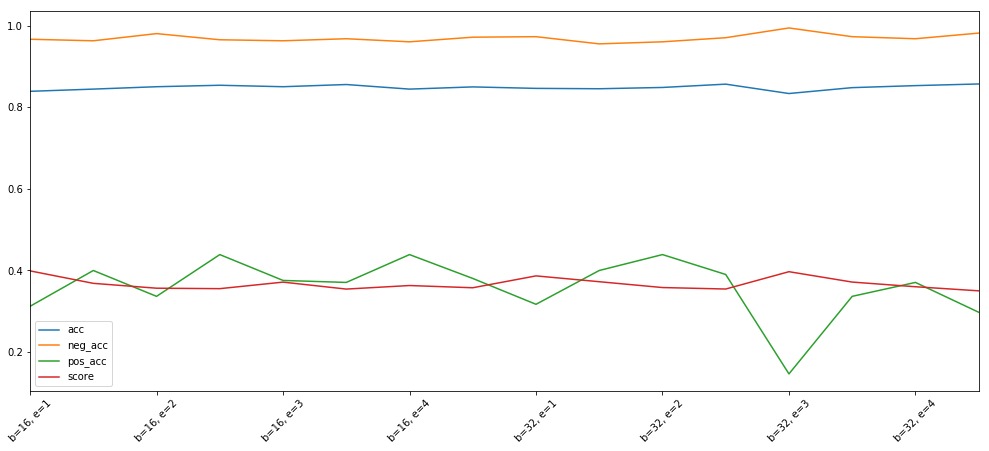

In [15]:
%matplotlib inline
import matplotlib
df = pd.DataFrame(results)

names = df.hyperparams
names = names.tolist()
names = pd.DataFrame(names)
names["label"] = "b=" + names["batch_size"].map(str) + ", e=" + names["epochs"].map(str)

ax = df.plot(rot=0, figsize= (17,7) )
ax.set_xticklabels(names.label, rotation = 45)